In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/gb-credit-default/sample_submission.csv
/kaggle/input/gb-credit-default/train.csv
/kaggle/input/gb-credit-default/test.csv


**Подключение библиотек, скриптов**

In [2]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from scipy.stats import (shapiro, 
                         probplot, 
                         mannwhitneyu, 
                         chi2_contingency)

import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [6]:
def plot_feature_with_target_statisctics(df, FEATURE_NAME, TARGET_NAME):
    feature_with_target = df[[FEATURE_NAME, TARGET_NAME]]
    feature = feature_with_target[FEATURE_NAME]
    feature_with_target_0 = feature[feature_with_target[TARGET_NAME] == 0]
    feature_with_target_1 = feature[feature_with_target[TARGET_NAME] == 1]
    
    print(shapiro(feature))
    print(mannwhitneyu(feature_with_target_0, feature_with_target_1))
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 5))
    sns.kdeplot(feature_with_target_0, shade=True, label='нет просрочки', color='g', ax=ax1)
    sns.kdeplot(feature_with_target_1, shade=True, label='просрочка', color='r', ax=ax1)
    ax1.grid()

    sns.pointplot(x=TARGET_NAME, y=FEATURE_NAME, data = feature_with_target, capsize=1, ax=ax2)
    ax2.set_title('Confidence interval (95%)')
    ax2.grid()
    plt.show()

In [7]:
TRAIN_DATASET_PATH = '/kaggle/input/gb-credit-default/train.csv'
TEST_DATASET_PATH = '/kaggle/input/gb-credit-default/test.csv'

## Загрузка данных
### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
* Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
* Monthly Debt - ежемесячный долг
* Credit Score - баллы кредитного рейтинга
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [8]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=",")
df_test = pd.read_csv(TEST_DATASET_PATH, sep=",")

# Предварительный, общий анализ данных

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [10]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [11]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Некоторые признаки имеют достаточно большое количество пропусков, также по разнице среднего и медианы по всем признакам имеются большие (потенциально выбросные) значения

In [12]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                    'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount',
                    'Current Credit Balance', 'Monthly Debt', 'Credit Score']
CAT_FEATURE_NAMES = ['Term', 'Years in current job', 'Home Ownership', 'Purpose']
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

## Целевая переменная

In [13]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Дисбаланс классов приблизительно в 2,5 раза

## Категориальные признаки

In [14]:
for col in df_train.select_dtypes(include='object').columns:
    print(str(col) + '\n\n' + str(df_train[col].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Признаки Home Ownership и Term можно преставить в ввиде dummy переменных.
Years in current job можно преобразовать в числовой вид.
Признак Purpose стоит проверить на возможность объединения категорий

## Корреляция числовых признаков с целевой переменной

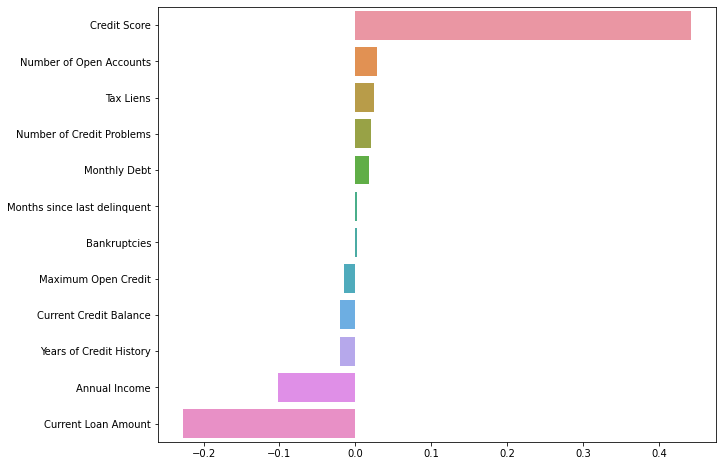

In [15]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.show()

Наиболее линейно скоррелированные признаки: Credit Score, Annual income, Current Loan Amount

## Матрица корреляций

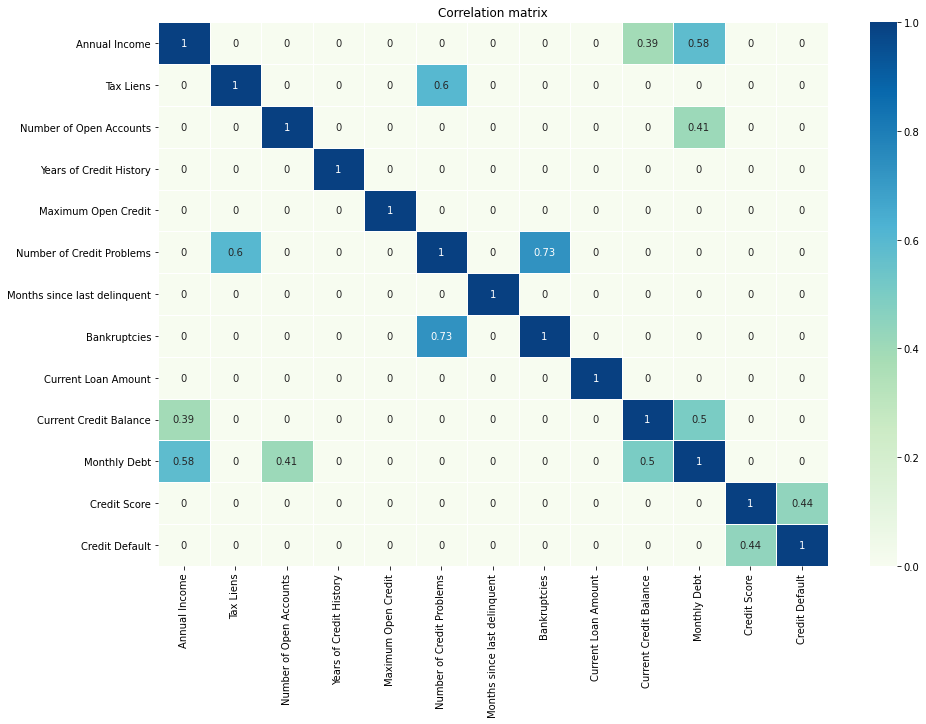

In [16]:
plt.figure(figsize=(15,10))
corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidth=0.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

Существуют достаточно сильно скоррелированные признаки, что нужно учитывать при обучении линейных моделей

# Сходство распределений на тренировочном и тестовом наборах данных

In [17]:
train_test_mannwhitneyu = pd.DataFrame()
for col in NUM_FEATURE_NAMES:
    train_test_mannwhitneyu = train_test_mannwhitneyu.append({'name': col, 'p-value': mannwhitneyu(df_train[col], df_test[col]).pvalue}
                                                             , ignore_index=True)
train_test_mannwhitneyu

,name,p-value
0,Annual Income,0.459082
1,Tax Liens,0.098369
2,Number of Open Accounts,0.221426
3,Years of Credit History,0.388695
4,Maximum Open Credit,0.383222
5,Number of Credit Problems,0.141958
6,Bankruptcies,0.036682
7,Current Loan Amount,0.123174
8,Current Credit Balance,0.371615
9,Monthly Debt,0.243695


* Уровень значимости по критерию Манна-Уитни для признака Bankrepticies меньше 0.05. Также достаточно низкие уровни значимости по признакам Tax Liens и Current Loan Ammount
* По остальным признакам в целом распределение на тесте похоже на трейн
* Таким образом признак Bankruptcies стоит попробовать исключить из модели, Остальные признаки следует рассмотреть подробнее.

### Категориальные признаки

Оценим сходство категориальных признаков на тренировочном и тестовом наборах данных с наиболее скоррелированными признаками Annual Income и Credit Score

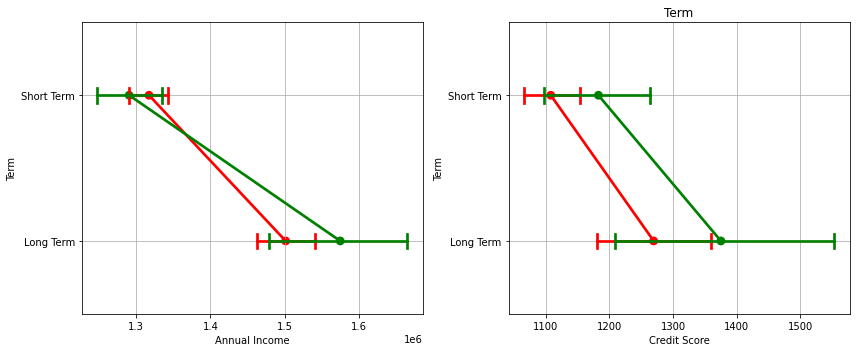

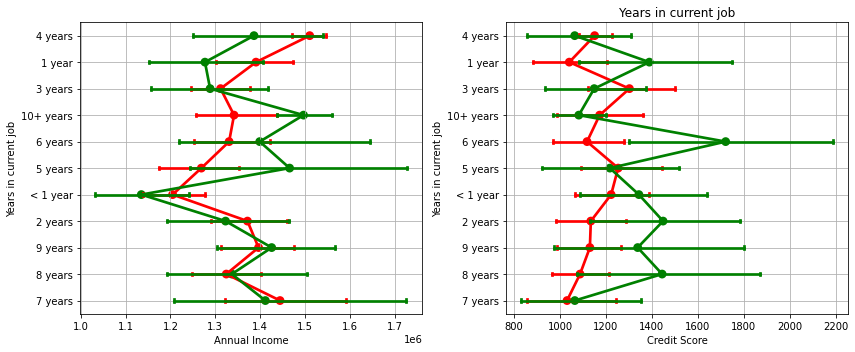

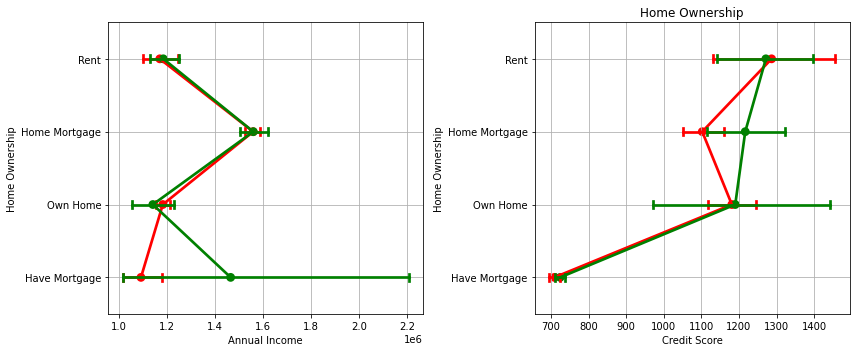

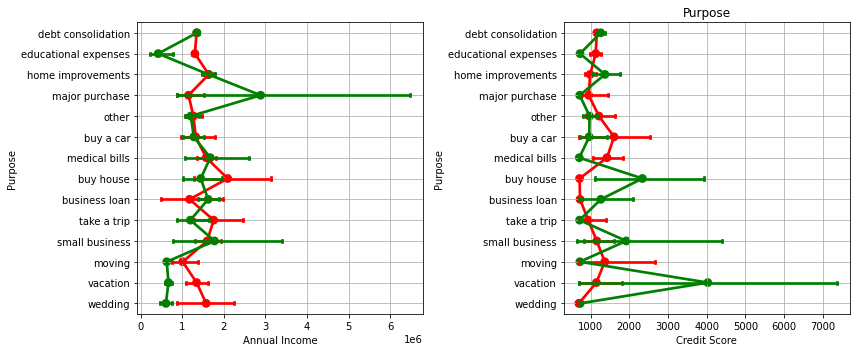

In [18]:
for col in CAT_FEATURE_NAMES:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 5))
    sns.pointplot(x='Annual Income', y=col, data=df_train, capsize=0.1, label='train', color='r', orient='h', ax=ax1)
    sns.pointplot(x='Annual Income', y=col, data=df_test, capsize=0.1, label='test', color='g', orient='h', ax=ax1)
    plt.title(col)
    ax1.grid()

    sns.pointplot(x='Credit Score', y=col, data=df_train, capsize=0.1, label='train', color='r', orient='h', ax=ax2)
    sns.pointplot(x='Credit Score', y=col, data=df_test, capsize=0.1, label='test', color='g', orient='h', ax=ax2)
    plt.title(col)
    ax2.grid()
    plt.tight_layout()
    plt.show()

Признаки Term и Home Ownership Более менее согласованы, признак Years in current job имеет смысл перевести в числовой. Признак purpose согласуется не очень хорошо. Поскольку признак Purpose имеет достаточно много уникальных значений, имеет смысл попробовать объеденить их в группы

# EDA

### Annual income

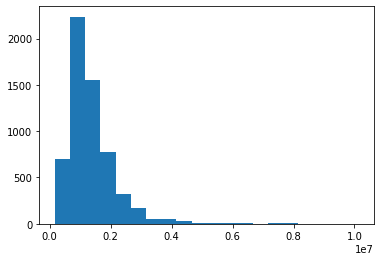

In [19]:
plt.hist(df_train['Annual Income'], bins=20)
plt.show()

Колличество клиентов с доходом > 3 000 000

In [20]:
len(df_train.loc[df_train['Annual Income'] > 3000000])

225

In [21]:
len(df_train.loc[df_train['Annual Income'].isna()])

1557

ShapiroResult(statistic=nan, pvalue=1.0)
MannwhitneyuResult(statistic=5534342.5, pvalue=0.031334788783133206)


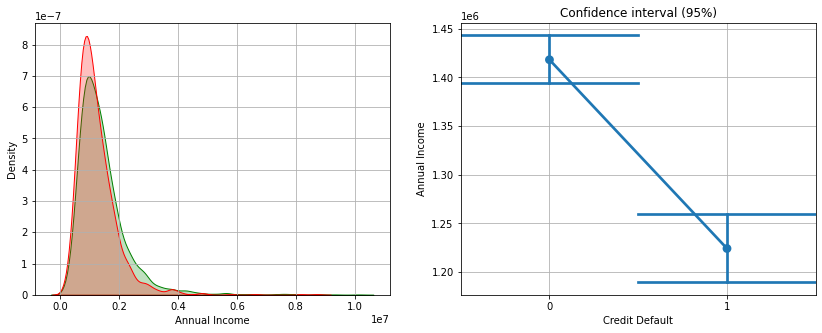

In [22]:
plot_feature_with_target_statisctics(df_train, 'Annual Income', TARGET_NAME)

Очень много пропусков. Также есть выбросные значения начиная с 3-4 миллионов, но при этом, не факт, что данные некорректны.
Признак кажется достаточно полезным, имеет смысл пообучать модель на заполнение пропусков

### Years in current job

In [23]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [24]:
len(df_train.loc[df_train['Years in current job'].isna()])

371

Возможно пропуски обозначают безработных. Переведем данные в числовой вид. Заполним пропуски нулями, тех кто работает менее 1 года закодируем как '1', 1 год как '2' и.т.д

In [25]:
df_train.loc[df_train['Years in current job'] == '< 1 year', 'Years in current job'] = '0 years'
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job'] = '-1 years'
df_train['Years in current job num'] = df_train['Years in current job'].str.extract('(-?\d+)').astype(int) + 1

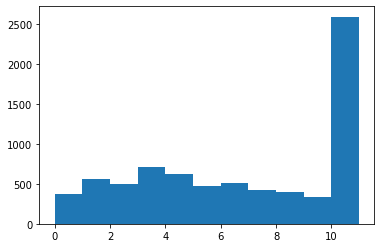

In [26]:
plt.hist(df_train['Years in current job num'], bins=11)
plt.show()

Распределение в целом однородное, не считая большого числа работников 10+

### Tax Liens

In [27]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

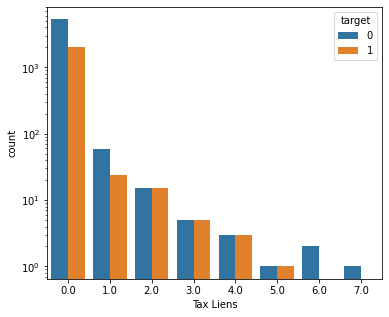

In [28]:
plt.figure(figsize=(6, 5))
sns.countplot(x='Tax Liens', hue='Credit Default', data=df_train, log=True)

plt.legend(title='target', loc='upper right')
plt.show()

Данный признак числовой, и скорее всего представляет просто число налоговых обременений. Учитывая явное преобладание 0, скорее всего признак не очень полезный. Можно также попробовать свести этот признак к бинарному, (имеются ли налоговые обременения), так как по графику частоты попадания в 1 класс кажутся немного выше при ненулевых значениях.

## Number of Open Accounts

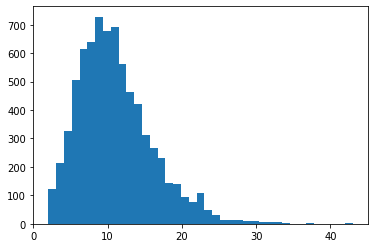

In [29]:
plt.hist(df_train['Number of Open Accounts'], bins = len(df_train['Number of Open Accounts'].value_counts()))
plt.show()

In [30]:
len(df_train.loc[df_train['Number of Open Accounts'] > 30])

27

Значения более 25-30 выглядят выбросно

## Years of Credit History

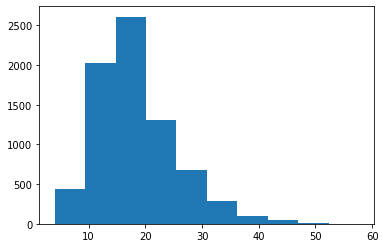

In [31]:
plt.hist(df_train['Years of Credit History'], bins = 10)
plt.show()

In [32]:
df_train['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.5      1
50.0      1
40.1      1
51.5      1
41.6      1
Name: Years of Credit History, Length: 408, dtype: int64

Вероятнее всего годы представлены с точностью до десятых, значения от 45-50 кажутся выбросами, жаль нет данных о возрастах клиентов

## Maximum Open Credit 

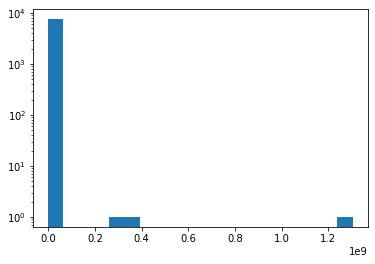

In [33]:
plt.hist(df_train['Maximum Open Credit'], bins = 20, log=True)
plt.show()

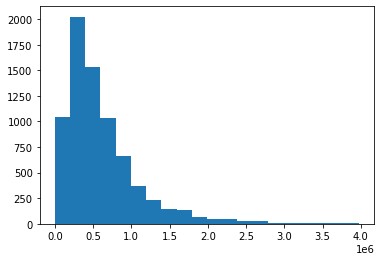

In [34]:
plt.hist(df_train.loc[df_train['Maximum Open Credit'] < 4000000, 'Maximum Open Credit'], bins = 20)
plt.show()

In [35]:
print(len(df_train.loc[df_train['Maximum Open Credit'] > 4000000, 'Maximum Open Credit']))
print(len(df_train.loc[df_train['Maximum Open Credit'] > 3000000, 'Maximum Open Credit']))

64
98


Максимальные величины кредита более 3-4 миллионов маловероятны

## Number of Credit Problems

In [36]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

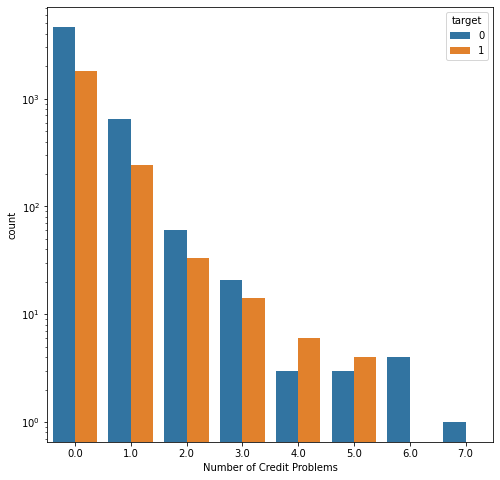

In [37]:
plt.figure(figsize=(8, 8))
sns.countplot(x='Number of Credit Problems', hue='Credit Default', data=df_train, log=True)

plt.legend(title='target', loc='upper right')
plt.show()

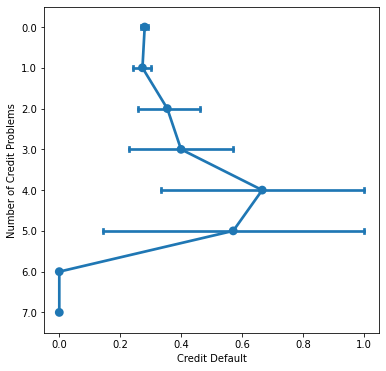

In [38]:
plt.figure(figsize=(6, 6))
sns.pointplot(x='Credit Default', y='Number of Credit Problems', data=df_train, capsize=0.1, orient='h')
plt.show()

Очень не равномерное распределение, значения более 4 маловероятны. Можно объеденить некоторые из значений или попробовать сделать признак бинарным, поскольку для значений 6 и 7 нет величин 1 класса, можно также приравнять их 5

## Months since last delinquent

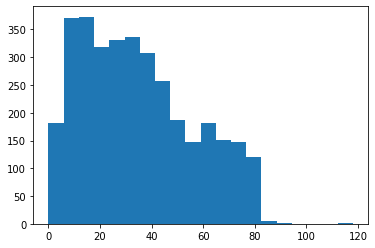

In [39]:
plt.hist(df_train['Months since last delinquent'], bins = 20)
plt.show()

In [40]:
len(df_train.loc[df_train['Months since last delinquent'].isna()])

4081

In [41]:
month_isna_to_target = df_train.loc[df_train['Months since last delinquent'].isna(), ['Months since last delinquent', 'Credit Default']]
month_isna_to_target['Credit Default'].value_counts()

0    2951
1    1130
Name: Credit Default, dtype: int64

In [42]:
len(df_train.loc[df_train['Months since last delinquent'] > 85])

4

Признак имеет очень много пропусков, с точки зрения логики задачи, пропуски могут означать отсутствие просрочек когда либо, поэтому их можно закодировать максимальным значением в выборке. Значения более 85 можно считать выбросами. Также можно попробовать сделать дискретизацию признака.

## Bankruptcies

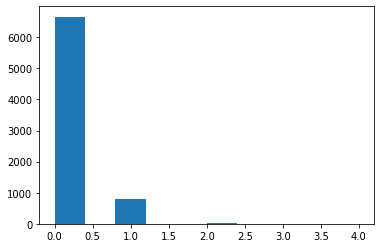

In [43]:
plt.hist(df_train['Bankruptcies'])
plt.show()

In [44]:
Bankruptcies_isna_to_target = df_train.loc[df_train['Bankruptcies'] == 0, ['Bankruptcies', 'Credit Default']]
Bankruptcies_isna_to_target['Credit Default'].value_counts()

0    4782
1    1878
Name: Credit Default, dtype: int64

In [45]:
Bankruptcies_isna_to_target = df_train.loc[df_train['Bankruptcies'] > 0, ['Bankruptcies', 'Credit Default']]
Bankruptcies_isna_to_target['Credit Default'].value_counts()

0    595
1    231
Name: Credit Default, dtype: int64

In [46]:
len(df_train.loc[df_train['Bankruptcies'] > 0])

826

ShapiroResult(statistic=nan, pvalue=1.0)
MannwhitneyuResult(statistic=5686353.0, pvalue=0.4567074598086799)


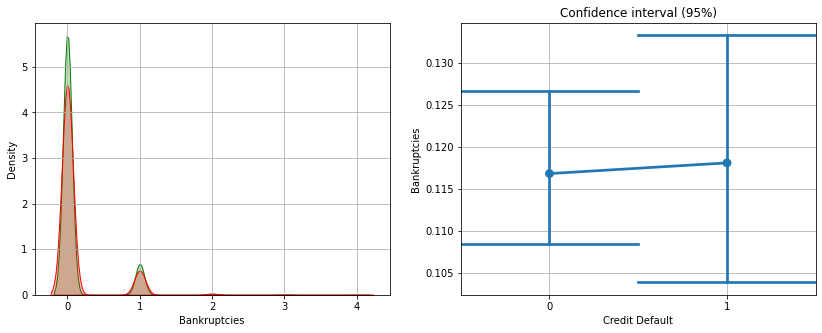

In [47]:
plot_feature_with_target_statisctics(df_train, 'Bankruptcies', TARGET_NAME)

Количество банкротов не велико. Частота невыполнения кредитных обязательств при наличии банкроства кажется выше. Учитывая отчилия распределений данного признака на трейне и тесте, а также сходство доверительных интервалов относительно целевой переменной, признак кажется не очень полезным. Пропуски можно заполнить модой.

## Purpose 

Попробуем объеденить некоторые значения признака

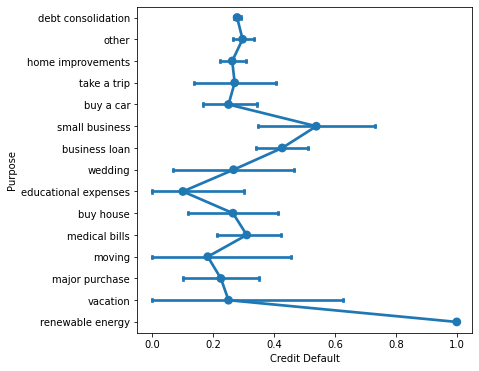

In [48]:
plt.figure(figsize=(6, 6))
sns.pointplot(x='Credit Default', y='Purpose', data=df_train, capsize=0.1, orient='h')
plt.show()

In [49]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [50]:
def add_merged_purpose(df):
    df.loc[df['Purpose'].isin(['debt consolidation', 'other', 'home improvements', 'take a trip',
                              'buy a car','buy house', 'medical bills']), 'merged_purpose'] = 0
    df.loc[df['Purpose'].isin(['wedding', 'educational expenses','moving',
                              'major purchase', 'vacation']), 'merged_purpose'] = 1
    df.loc[df['Purpose'].isin(['small business', 'business loan', 
                               'renewable energy']), 'merged_purpose'] = 2
    return df

In [51]:
df_train = add_merged_purpose(df_train)
df_test = add_merged_purpose(df_test)
df_train['merged_purpose'].value_counts()

0.0    7259
2.0     157
1.0      84
Name: merged_purpose, dtype: int64

Учитывая количество уникальных значений renewable energy отнесем их также во второй класс.

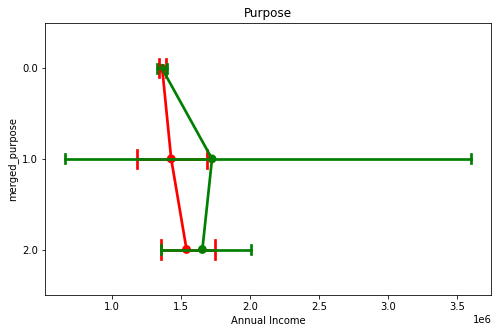

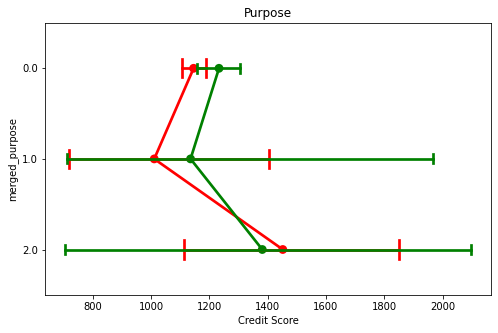

In [52]:
control_features = ['Annual Income', 'Credit Score']
for control_feature in control_features:
    plt.figure(figsize=(8,5))
    sns.pointplot(x=control_feature, y='merged_purpose', data=df_train, capsize=0.2, label='train', color='r', orient='h')
    sns.pointplot(x=control_feature, y='merged_purpose', data=df_test, capsize=0.1, label='test', color='g', orient='h')
    plt.title(col)
    plt.show()

## Current Loan Amount

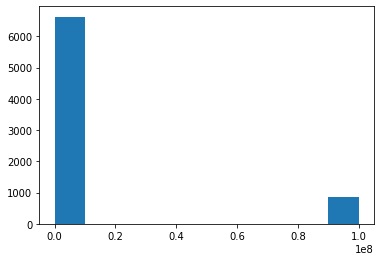

In [53]:
plt.hist(df_train['Current Loan Amount'])
plt.show()

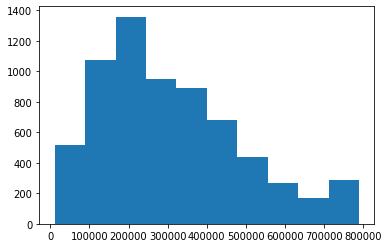

In [54]:
plt.hist(df_train.loc[df_train['Current Loan Amount'] < 1000000, 'Current Loan Amount'])
plt.show()

In [55]:
len(df_train.loc[df_train['Current Loan Amount'] > 1000000])

870

ShapiroResult(statistic=0.9398760199546814, pvalue=1.401298464324817e-45)
MannwhitneyuResult(statistic=4375163.0, pvalue=2.2854679965680805e-08)


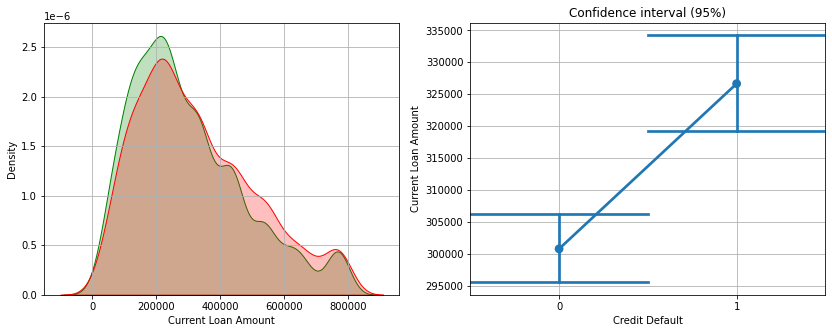

In [56]:
plot_feature_with_target_statisctics(df_train.loc[df_train['Current Loan Amount'] < 1000000], 'Current Loan Amount', 'Credit Default')

Признак кажется достаточно полезным, но при этом имеется большое количество одинаковых выбросов == 99999999, согласно логике задачи, это что то вроде бесконечного кредита, можно либо посчитать их как выбросы или пропуски, либо приравнять максимальному значению.

## Current Credit Balance

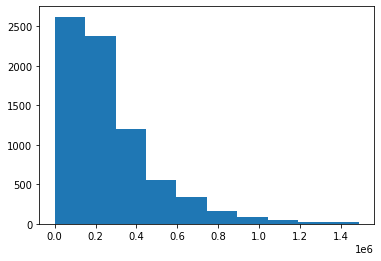

In [57]:
plt.hist(df_train.loc[df_train['Current Credit Balance'] < 1500000, 'Current Credit Balance'])
plt.show()

Значения более 1 200 000  кажутся выбросами

## Monthly Debt

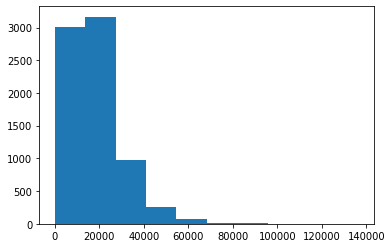

In [58]:
plt.hist(df_train['Monthly Debt'])
plt.show()

ShapiroResult(statistic=0.8937593698501587, pvalue=0.0)
MannwhitneyuResult(statistic=5534935.5, pvalue=0.03183394406726229)


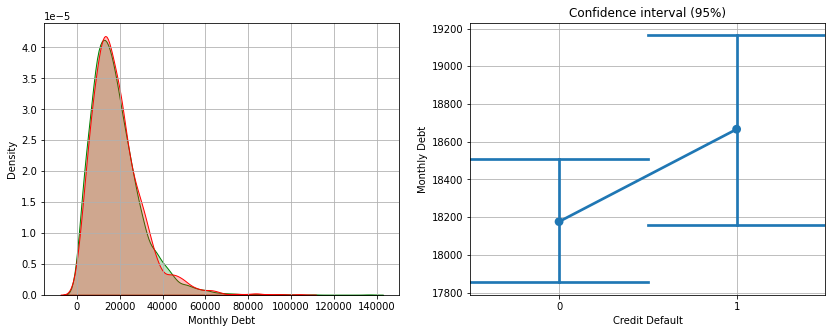

In [59]:
plot_feature_with_target_statisctics(df_train, 'Monthly Debt', 'Credit Default')

In [60]:
len(df_train.loc[df_train['Monthly Debt'] > 80000])

17

Значения более 70-80 тыс кажутся выбросами

## Credit score

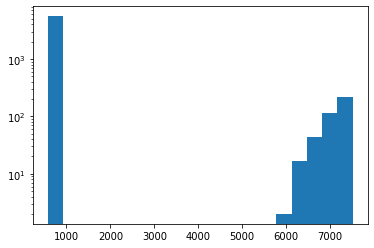

In [61]:
plt.hist(df_train['Credit Score'], bins=20, log=True)
plt.show()

In [62]:
df_train.loc[df_train['Credit Score'].between(1000, 6000)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Years in current job num,merged_purpose


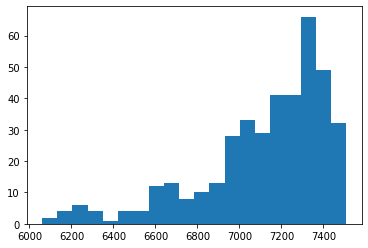

In [63]:
plt.hist(df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'], bins=20)
plt.show()

ShapiroResult(statistic=nan, pvalue=1.0)
MannwhitneyuResult(statistic=5197665.0, pvalue=2.4094608408145815e-09)


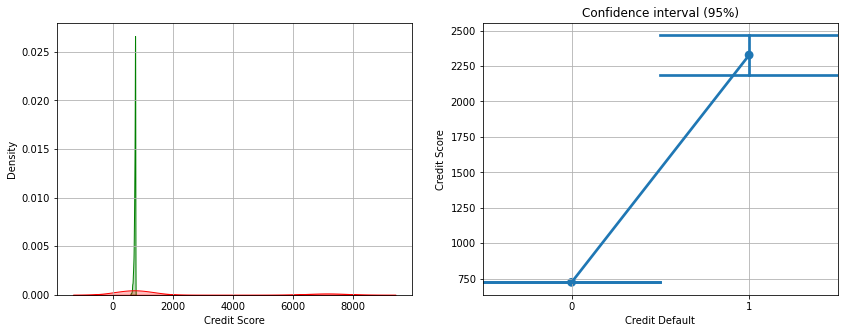

In [64]:
plot_feature_with_target_statisctics(df_train, 'Credit Score', 'Credit Default')

Большой провал в величинах от 1000 до 6000, в признаке очень много нулей и пропусков, 
при этом признак хорошо скоррелирован с целевой переменной и кажется полезным.
Кажется логичным прировнять пропуски нулю. Можно также попробовать все значения кредитного счета больше 6000 сместить на 5000

# Data Preprocessing

In [65]:
class DataPreprocessing:

    def __init__(self):
        self.medians = None
        
    def fit(self, X):  
        self.medians = X.median()
        self.modes = X.mode().iloc[0]
        
    def transform(self, X_input):
        X = X_input.copy(deep=True)
        
        # Home Ownership
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'], prefix='Ownership')], axis=1)
        X.drop(['Home Ownership'], axis=1, inplace=True)
        
        # Annual Income
        X['Bad Annual Income'] = 0
        X.loc[X['Annual Income'].isna() | X['Annual Income'] > 4000000, 'Bad Annual Income'] = 1
        X.loc[X['Annual Income'] > 4000000, 'Annual Income'] = self.medians['Annual Income']
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        
        
        # Years in current job
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = '0 years'
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = '-1 years'
        X['Years in current job num'] = X['Years in current job'].str.extract('(-?\d+)').astype(int) + 1
        X.drop(['Years in current job'], axis=1, inplace=True)
        
        # Tax Liens
        X.loc[X['Tax Liens'].isna(), 'Tax Liens'] = self.modes['Tax Liens']
        X['Has_Liens'] = 0
        X.loc[X['Tax Liens'] > 0.5, 'Has_Liens'] = 1
        
        # Number of Open Accounts
        X.loc[X['Number of Open Accounts'] > 30, 
              'Number of Open Accounts'] = self.medians['Number of Open Accounts']
        
        # Years of Credit History 
        X.loc[X['Years of Credit History'] > 50, 
                     'Years of Credit History'] = self.medians['Years of Credit History']
        
        #Maximum Open Credit
        X.loc[X['Maximum Open Credit'] > 4000000,
                     'Maximum Open Credit'] = self.medians['Maximum Open Credit']
        
        # Number of Credit Problems
        X.loc[X['Number of Credit Problems'] > 5,
                     'Number of Credit Problems'] = 5
        
        #Months since last delinquent (можно попробовать также 85 заменить на Max)
        X.loc[X['Months since last delinquent'] > 85, 'Months since last delinquent'] = 85
        X.loc[X['Months since last delinquent'].isna(),'Months since last delinquent'] = 85
        
        # Bankrupticies
        # X.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = 0
        X.drop(['Bankruptcies'], axis=1, inplace=True)
        
        # Purpose
        X['Purpose'].fillna(self.modes['Purpose'])
        # X = pd.concat([X, pd.get_dummies(X['Purpose'])], axis=1)
        X.loc[X['Purpose'].isin(['debt consolidation', 'other', 'home improvements', 'take a trip',
                              'buy a car','buy house', 'medical bills']), 'merged_purpose'] = 0
        X.loc[X['Purpose'].isin(['wedding', 'educational expenses','moving',
                                  'major purchase', 'vacation']), 'merged_purpose'] = 1
        X.loc[X['Purpose'].isin(['small business', 'business loan', 
                                   'renewable energy']), 'merged_purpose'] = 2
        X.drop(['Purpose'], axis=1, inplace=True)
        
        # Term
        X = pd.concat([X, pd.get_dummies(X['Term'])], axis=1)
        X.drop(['Term'], axis=1, inplace=True)
             
        # Current Credit Balance
        X.loc[X['Current Credit Balance'] > 1500000, 
              'Current Credit Balance'] = self.medians['Current Credit Balance']
        
        # Credit Score
        X.loc[X['Credit Score'].isna(),'Credit Score'] = self.medians['Credit Score']
        
        X.fillna(self.medians, inplace=True)
        return X

# BASELINE

In [66]:
class DataPreprocessing_baseline:

    def __init__(self):
        self.medians = None
        
    def fit(self, X):  
        self.medians = X.median()
        
    def transform(self, X_input):
        
        X = X_input.copy(deep=True)
        # Заполняем пропуски
        X.loc[df_train['Annual Income'].isna(), 'Annual Income'] = X['Annual Income'].median()
        X.loc[df_train['Bankruptcies'].isna(), 'Bankruptcies'] = X['Bankruptcies'].median()   
        X.loc[df_train['Credit Score'].isna(), 'Credit Score'] = X['Credit Score'].mean()
        X.drop(['Months since last delinquent'], axis=1, inplace=True)
        
        # Term
        X = pd.concat([X, pd.get_dummies(X['Term'])], axis=1)
        X.drop(['Term'], axis=1, inplace=True)
    
        # Years in current job
        X.loc[X['Years in current job'] == '< 1 year', 'Years in current job'] = '0 years'
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = '-1 years'
        X['Years in current job num'] = X['Years in current job'].str.extract('(-?\d+)').astype(int) + 1
        X.drop(['Years in current job'], axis=1, inplace=True)
        
        # Home Ownership
        X = pd.concat([X, pd.get_dummies(X['Home Ownership'], prefix='Ownership')], axis=1)
        X.drop(['Home Ownership'], axis=1, inplace=True)
        
        # Purpose
        X = pd.concat([X, pd.get_dummies(X['Purpose'], prefix='Purpose')], axis=1)
        X.drop(['Purpose'], axis=1, inplace=True)
        
        X.fillna(self.medians, inplace=True)
        return X

# Генерация фич

In [67]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=",")
preprocessor = DataPreprocessing()
preprocessor.fit(df_train)
df_train_EDA = preprocessor.transform(df_train)

In [68]:
def income_to_cat(df):
    train_income_max = df['Annual Income'].max()
    bins = [0, 500000, 1000000, 2000000, 3000000, train_income_max]
    df['income_cat'] = pd.cut(df['Annual Income'], bins=bins, labels=False)
    df['income_cat'].fillna(-1, inplace=True)
    return df

In [69]:
df_train_EDA = income_to_cat(df_train_EDA)
df_train_EDA['income_cat'].value_counts()

2    4514
1    1974
3     620
0     258
4     134
Name: income_cat, dtype: int64

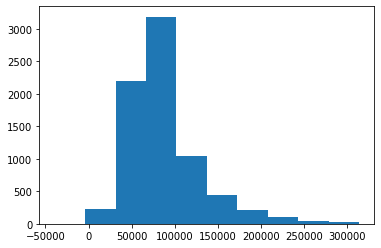

In [70]:
df_train_EDA['month_income_to_debt'] = (df_train_EDA['Annual Income'] / 12).sub(df_train_EDA['Monthly Debt'])
plt.hist(df_train_EDA['month_income_to_debt'])
plt.show()

In [71]:
class Feature_generator:
    def transform(self, df):
        train_income_max = df['Annual Income'].max()
        bins = [0, 500000, 1000000, 2000000, 3000000, train_income_max]
        df['income_cat'] = pd.cut(df['Annual Income'], bins=bins, labels=False)
        df['income_cat'].fillna(-1, inplace=True)
        
        df_train_EDA['month_income_to_debt'] = (df_train_EDA['Annual Income'] / 12).sub(df_train_EDA['Monthly Debt'])
        return df

### Перебор моделей

In [72]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21, class_weight={0:1, 1:2.55}, max_depth=6)
    model_xgb = xgb.XGBClassifier(random_state=21, max_depth=2, n_estimators=100)
    model_lgbm = lgbm.LGBMClassifier(random_state=21, class_weight={0:1, 1:2.55}, max_depth=2)
    model_catb = catb.CatBoostClassifier(random_state=21, silent=True)
    models = {'lr': model_lr,
              'knn': model_knn,
              'tree': model_tree,
              'xgb': model_xgb,
              'lgbm': model_lgbm,
              'catb': model_catb,
             }
    return models

def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

def fit_models(df):
    # Determine features
    TARGET_NAME = 'Credit Default'
    TRAIN_FEATURE_NAMES = [name for name in df if name != TARGET_NAME]
    
    # scale numeric features
    scaler = StandardScaler()
    df[TRAIN_FEATURE_NAMES] = scaler.fit_transform(df[TRAIN_FEATURE_NAMES])

    # train-test split
    X = df[TRAIN_FEATURE_NAMES]
    y = df[TARGET_NAME]
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.2, 
                                                        shuffle=True, 
                                                        random_state = 42,
                                                        stratify=y)
    
    models = init_models()
    output_statistic = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        report_train = classification_report(y_train, y_train_pred, output_dict=True)
        report_test = classification_report(y_test, y_test_pred, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)
        overfiting_f1_macro = f1_macro_train - f1_macro_test
        overfiting_f1_0 = f1_0_train - f1_0_test
        overfiting_f1_1 = f1_1_train - f1_1_test
        output_statistic = output_statistic.append({'model_name': name,
                                                    'f1_macro_test': f1_macro_test,
                                                    'f1_0_test': f1_0_test,
                                                    'f1_1_test': f1_1_test,
                                                    'overfiting_f1_macro': overfiting_f1_macro,
                                                    'overfiting_f1_0': overfiting_f1_0,
                                                    'overfiting_f1_1': overfiting_f1_1
                                                    }, ignore_index=True)
    return output_statistic, models

### Обучение и оценка моделей

In [73]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=",")

## Обучение по baseline

In [74]:
preprocessor = DataPreprocessing_baseline()
preprocessor.fit(df_train)
df_train_baseline = preprocessor.transform(df_train)
results, models = fit_models(df_train_baseline)
results

[16:28:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,f1_0_test,f1_1_test,f1_macro_test,model_name,overfiting_f1_0,overfiting_f1_1,overfiting_f1_macro
0,0.861883,0.434635,0.648259,lr,0.002587,-0.009307,-0.003360
1,0.819572,0.419128,0.619350,knn,0.060628,0.185956,0.123292
2,0.771358,0.525128,0.648243,tree,0.020390,0.026868,0.023629
3,0.858947,0.464000,0.661474,xgb,0.018994,0.057525,0.038260
4,0.778770,0.546748,0.662759,lgbm,0.027398,0.039459,0.033428
5,0.858467,0.463259,0.660863,catb,0.057253,0.242800,0.150026


## Обучение с учетом анализа данных и отбор признаков

In [75]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=",")
preprocessor = DataPreprocessing()
preprocessor.fit(df_train)
df_train_EDA = preprocessor.transform(df_train)
feature_gen = Feature_generator()
df_train_EDA = feature_gen.transform(df_train_EDA)
# df_train_EDA.columns.to_list()

In [76]:
FEATURES = ['Annual Income',
 #'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Ownership_Have Mortgage',
 'Ownership_Home Mortgage',
 'Ownership_Own Home',
 'Ownership_Rent',
 'Bad Annual Income',
 'Years in current job num',
 'Has_Liens',
 'merged_purpose',
 'Long Term',
 #'Short Term',
 #'income_cat',
 #'month_income_to_debt'
           ]

In [77]:
results, models = fit_models(df_train_EDA[FEATURES])
results

[16:29:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,f1_0_test,f1_1_test,f1_macro_test,model_name,overfiting_f1_0,overfiting_f1_1,overfiting_f1_macro
0,0.867707,0.431095,0.649401,lr,-0.006748,-0.027393,-0.017070
1,0.817460,0.434426,0.625943,knn,0.062210,0.168726,0.115468
2,0.777723,0.522560,0.650142,tree,0.024488,0.029914,0.027201
3,0.860877,0.474522,0.667700,xgb,0.017111,0.042220,0.029665
4,0.780149,0.550254,0.665201,lgbm,0.025020,0.041230,0.033125
5,0.856662,0.450886,0.653774,catb,0.062732,0.269204,0.165968


В качестве основной модели выберем xgboost, переберем различные методы балансировки классов

In [78]:
def balance_by_target(df, target_name, method):
    assert method in ['over', 'under', 'tomek', 'smote'], 'неверный метод'
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    disbalance_coef = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coef):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        rng = np.random.seed(21)
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)
    elif method =='tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=22)
        x_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([x_smote, y_smote], axis=1)
    return df.sample(frac=1)

In [79]:
# Determine features
TARGET_NAME = 'Credit Default'

df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=",")
X = df_train[[name for name in df_train if name != TARGET_NAME]]
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    shuffle=True, 
                                                    random_state = 42,
                                                    stratify=y)
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

#balancing
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_by_target(df_for_balancing, TARGET_NAME, 'over')

X_train = df_balanced.drop(columns=TARGET_NAME, axis=1)
y_train = df_balanced[TARGET_NAME]

# scale features
# scaler = StandardScaler()
# X_train[TRAIN_FEATURE_NAMES] = scaler.fit_transform(X_train[TRAIN_FEATURE_NAMES])
# X_test[TRAIN_FEATURE_NAMES] = scaler.transform(X_test[TRAIN_FEATURE_NAMES])

In [80]:
model_xgb = xgb.XGBClassifier(random_state=21, max_depth=1, n_estimators=100, )
model_xgb.fit(X_train, y_train)
evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

[16:29:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.70      0.85      0.77      4310
           1       0.74      0.52      0.61      3380

    accuracy                           0.71      7690
   macro avg       0.72      0.69      0.69      7690
weighted avg       0.71      0.71      0.70      7690

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1077
           1       0.52      0.52      0.52       423

    accuracy                           0.73      1500
   macro avg       0.67      0.67      0.67      1500
weighted avg       0.73      0.73      0.73      1500

CONFUSION MATRIX

col_0             0    1
Credit Default          
0            

Наилучшая метрика на тесте при применении smote на проявляется сильное переобучение поэтому выберем over

In [81]:
submit = pd.read_csv('/kaggle/input/gb-credit-default/sample_submission.csv')
submit.head(5)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [82]:
df_test = pd.read_csv(TEST_DATASET_PATH, sep=",")
df_test = preprocessor.transform(df_test)
#df_test[TRAIN_FEATURE_NAMES] = scaler.transform(df_test[TRAIN_FEATURE_NAMES])
prediction = model_xgb.predict(df_test)

In [83]:
len(prediction)

2500

In [84]:
submit['Credit Default'] = prediction
submit.head()

,Id,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0


In [85]:
submit.to_csv('rf_submit.csv', index=False)